In [2]:
import pickle
import pydicom as dicom 
import matplotlib.pylab as plt
import numpy as np
import os
import pandas as pd
import torch

(3518, 2800)


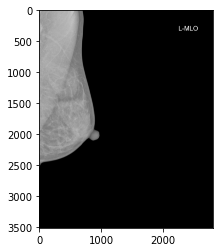

In [92]:
image_path = '2ddfad7286c2b016931ceccd1e2c7bbc.dicom'
ds = dicom.dcmread(image_path)
print(ds.pixel_array.shape)
plt.imshow(ds.pixel_array, cmap='gray') #.pixel_array is pixel data

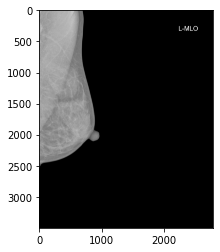

In [91]:
plt.imshow(ds.pixel_array[:3500,:], cmap='gray') #.pixel_array is pixel data

In [8]:
path = '/Users/Benjamin/Desktop/Projects/mammography/preprocessing/TestFolder'
path2 = '/Users/Benjamin/Desktop/Projects/mammography/preprocessing/placement'
# for im in os.listdir(path):
#     pickle.load(open(f'{path}/{im}','rb'))
for im in os.listdir(path):
    if im != '.DS_Store':
        print(im)
        ds = dicom.dcmread(f'{path}/{im}')
        ds.pixel_array 

451562831387e2822923204cf8f0873e.dicom
fcf12c2803ba8dc564bf1287c0c97d9a.dicom


In [20]:
test_set = {}
train_set = {}
laterality_view = {}
left_breast_birad = {}
right_breast_birad = {}

df = pd.read_csv('breast-level_annotations.csv')
for i in range(df.shape[0]): #Go through every row 
    row_data = df.iloc[i] #Specific row
    study_id = row_data['study_id'] #Patient ID
    split = row_data['split'] # Train or test 
    image_id = row_data['image_id'] #Image ID
    
    laterality = row_data['laterality'] #Laterality
    view = row_data['view_position'] #View
    birad = row_data['breast_birads'][-1:] #rating of breast cancer
    
    
    lat_view_tup = (laterality, view) # Tuple to check in later loop
    
    #Dictionary that makes it easy to find axis later in main()
    if lat_view_tup == ('L','CC'):
        laterality_view[image_id] = 0
    elif lat_view_tup == ('L','MLO'):
        laterality_view[image_id] = 1
    elif lat_view_tup == ('R','CC'):
        laterality_view[image_id] = 2
    elif lat_view_tup == ('R','MLO'):
        laterality_view[image_id] = 3
        
    #Dictionaries that find BIRADS for each breast on each patient 
    if laterality == "L":
        if study_id not in left_breast_birad.keys():
            left_breast_birad[study_id] = birad
        else:
            if left_breast_birad[study_id] != birad:
                print('Issue; Left breast BIRADs do not match')
    elif laterality == "R":
        if study_id not in right_breast_birad.keys():
            right_breast_birad[study_id] = birad
        else:
            if right_breast_birad[study_id] != birad:
                print('Issue; right breast BIRADs do not match')
    
    #Splitting image_ids into test or train based on patient 
    if split == 'training':
        if study_id not in train_set.keys():
            train_set[study_id] = [image_id]
        else:
            train_set[study_id].append(image_id)
    
    elif split == 'test':
        if study_id not in test_set.keys():
            test_set[study_id] = [image_id]
        else:
            test_set[study_id].append(image_id)
            
#Dictionary that contains tuple of (left_birad, right_birad)
assert(len(left_breast_birad) == len(right_breast_birad))
left_right_birad = {}
for key in right_breast_birad.keys():
    right_birad = right_breast_birad[key]
    left_birad = left_breast_birad[key]
    left_right_birad[key] = (left_birad,right_birad)

In [93]:
def main():
    path1 = '' #need to input correct path name that refers to all patient
    path2 = '' #Where to save data (needs to have test and train folders)
    
    for patient in os.listdir(path): #going into each patient folder
        patient_tensor = torch.zeros(4,3518,2800) #Tensor that has all 4 scans of patient that are (3518,2800)
        i = 0
        for scan in os.listdir(f'{path}/{patient}'): #Going into each scan
            ds = dicom.dcmread(f'{path}/{patient}/{scan}') #Reading scan via dicom (can't figure out open)
            correct_type_array = np.ascontiguousarray(ds.pixel_array[:3500,:],dtype = np.float32)
            scan_array = torch.from_numpy(correct_type_array) #making array (3500,2800) good numbers
            axis = laterality_view[scan] #Checking dictionary to see what laterality and view it is
            patient_tensor[axis,:,:] = scan_array #Putting it in correct dimension 
            i += 1
        assert(i == 4) #Checking all four scans were done
        
        patient_readings = left_right_birad[patient]
        patient_list = (patient_tensor, patient_readings) # tuple of (tensor, (left birad, right birad))
        
        #Saving to correct data subfolder
        if patient in training.keys():
            pickle.dump(patient_list, open(f'{path}/train/{patient}.pt', "wb"))
        else:
            pickle.dump(patient_list, open(f'{path}/test/{patient}.pt', "wb"))
            
#At the end of preprocessing, path2/ should have two folders: test and train, each of which have 
#hundreds of .pt files that each are a tuple of array (4,3518,2800) and tuple (left, right)
#
#The goal of training and testing should be for looping through each of these .pt files, training on array and compare
#to tuple 